<a href="https://colab.research.google.com/github/AnantChandra/google-colab/blob/main/rohlik_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anantchandra","key":"0d4a00a1837c8993c7fc12089269e19e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c rohlik-sales-forecasting-challenge-v2

 89% 42.0M/47.3M [00:00<00:00, 112MB/s] 
100% 47.3M/47.3M [00:00<00:00, 109MB/s]


In [5]:
!unzip rohlik-sales-forecasting-challenge-v2.zip

Archive:  rohlik-sales-forecasting-challenge-v2.zip
  inflating: calendar.csv            
  inflating: inventory.csv           
  inflating: sales_test.csv          
  inflating: sales_train.csv         
  inflating: solution.csv            
  inflating: test_weights.csv        


In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

In [7]:
sales_train = pd.read_csv('sales_train.csv', parse_dates=['date'])
sales_test = pd.read_csv('sales_test.csv', parse_dates=['date'])
inventory = pd.read_csv('inventory.csv')
calendar = pd.read_csv('calendar.csv', parse_dates=['date'])
test_weights = pd.read_csv('test_weights.csv')
solution = pd.read_csv('solution.csv')

In [8]:
sales_train = pd.merge(sales_train, inventory, how='left', on =['unique_id','warehouse'])
sales_test = pd.merge(sales_test, inventory, how='left', on =['unique_id','warehouse'])

In [9]:
for df in [sales_train,sales_test]:
    df.set_index('date',inplace=True)

In [10]:
np.setdiff1d(sales_train.columns, sales_test.columns)

array(['availability', 'sales'], dtype=object)

In [11]:
sales_train.drop(['availability'], axis=1, inplace=True)
sales_train.sort_values(['date','warehouse'], inplace=True)

In [12]:
from scipy.stats import kurtosis

In [13]:
result = sales_train.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),
    date_difference=('date', lambda x: x.max() - x.min()),
    var_sales = ('sell_price_main','var'),
    mean_price = ('sell_price_main','mean'),
    skew_price = ('sell_price_main','skew'),
    max_price = ('sell_price_main','max'),
    kurtosis_sales = ('sell_price_main',kurtosis)
)

In [14]:
result

,count,first_date,last_date,date_difference,var_sales,mean_price,skew_price,max_price,kurtosis_sales
warehouse,,,,,,,,,
Brno_1,643637,2020-08-01,2024-06-02,1401 days,5108.657471,67.873869,2.826800,1015.51,11.636842
Budapest_1,574582,2020-08-01,2024-06-02,1401 days,822068.394919,918.184147,4.306405,21682.99,34.278188
Frankfurt_1,198937,2021-12-08,2024-06-02,907 days,10.047742,2.977863,6.456303,50.15,69.010019
Munich_1,259333,2021-05-20,2024-06-02,1109 days,7.316594,3.002412,4.059457,38.75,33.219987
Prague_1,780566,2020-08-01,2024-06-02,1401 days,4496.440265,65.941507,2.614916,1112.54,9.307276
Prague_2,770709,2020-08-01,2024-06-02,1401 days,4287.697391,65.624530,2.540218,994.18,8.578498
Prague_3,779655,2020-08-01,2024-06-02,1401 days,4970.689358,67.141527,2.560767,963.01,8.294052


In [15]:
result = sales_test.reset_index().groupby(['warehouse']).agg(
    count = ('date','size'),
    first_date = ('date','min'),
    last_date = ('date','max'),
    date_difference= ('date', lambda x: (x.max() - x.min()).days+1)
)

In [16]:
result

,count,first_date,last_date,date_difference
warehouse,,,,
Brno_1,7196,2024-06-03,2024-06-16,14
Budapest_1,6576,2024-06-03,2024-06-16,14
Frankfurt_1,3222,2024-06-03,2024-06-16,14
Munich_1,3907,2024-06-03,2024-06-16,14
Prague_1,8714,2024-06-03,2024-06-16,14
Prague_2,8655,2024-06-03,2024-06-16,14
Prague_3,8751,2024-06-03,2024-06-16,14


In [17]:
del result

In [18]:
u_warehouses = sales_train['warehouse'].unique()

In [19]:
!pip install colorama
from colorama import Style, Fore

for w in u_warehouses:
    missing = pd.date_range(
        start=sales_train.loc[sales_train.warehouse==w].index.min(),
        end=sales_train.loc[sales_train.warehouse==w].index.max()
        ).difference(sales_train.loc[sales_train.warehouse==w].index)

    if missing.size > 0:
        print(f'{Style.BRIGHT}{Fore.BLUE}**{w}**{Style.RESET_ALL}')
        first_date = sales_train.loc[sales_train.warehouse==w].index.min().strftime("%Y-%m-%d")
        last_date  = sales_train.loc[sales_train.warehouse==w].index.max().strftime("%Y-%m-%d")
        print(f'{Style.BRIGHT}{Fore.YELLOW} Missing Dates-> {Style.RESET_ALL}{pd.date_range(start=sales_train.loc[sales_train.warehouse==w].index.min(),end=sales_train.loc[sales_train.warehouse==w].index.max()).difference(sales_train.loc[sales_train.warehouse==w].index)}\n')

**Munich_1**
 Missing Dates-> DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', freq='D')

**Frankfurt_1**
 Missing Dates-> DatetimeIndex(['2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01', '2022-01-02', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15',
               '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-

In [20]:
sales_train[sales_train.sales.isnull()]['warehouse'].value_counts()

,count
warehouse,
Munich_1,46
Frankfurt_1,6


In [21]:
cat_cols = list(sales_test.select_dtypes(include='O'))
num_cols = list(sales_test._get_numeric_data())
target = 'sales'
initial_features = list(sales_test.columns)

In [22]:
for c in cat_cols:
    A = sales_train[c].fillna('None').astype(str).unique()
    B = sales_test[c].fillna('None').astype(str).unique()
    C = np.setdiff1d(B,A)
    if C.size>0:
        print(C)
        sales_train.iloc[~sales_train[c].isin(C), c ] = 'None'
    sales_train[c] = sales_train[c].astype('category')
    sales_test[c] = sales_test[c].astype('category')

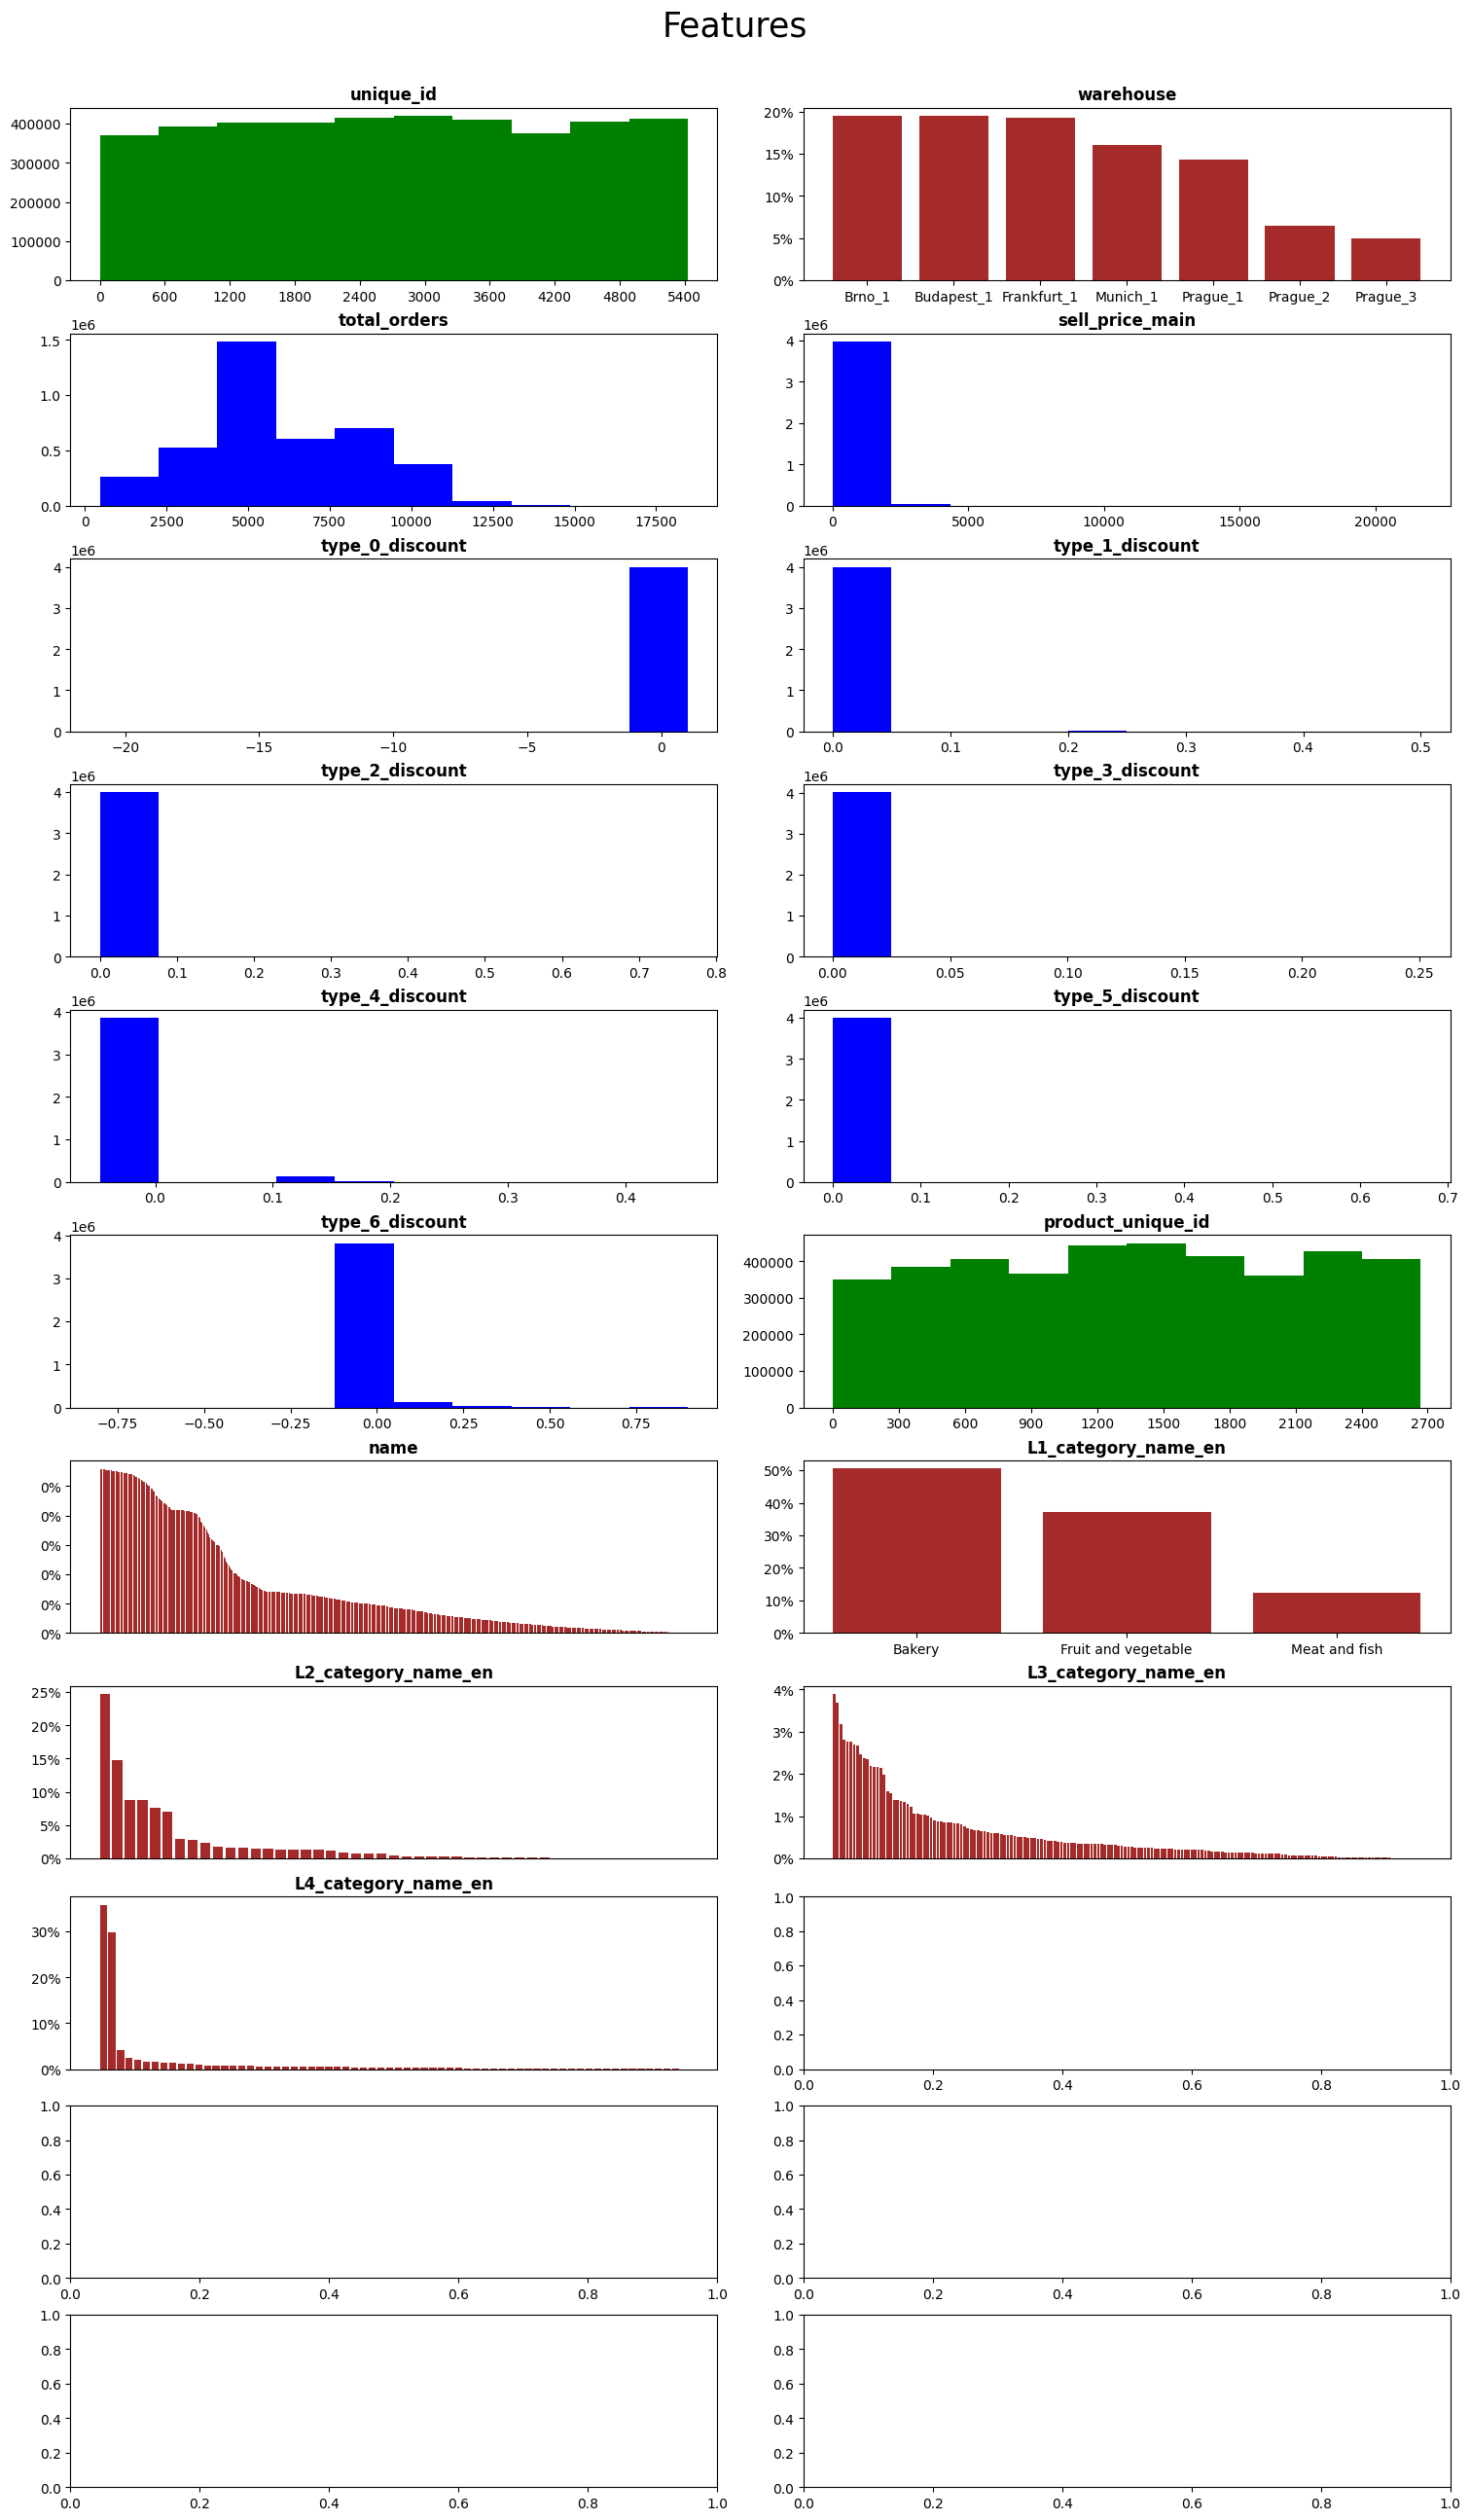

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs= plt.subplots(11,2, figsize=(15,25),  constrained_layout=True)
for c, ax in zip(initial_features, axs.ravel()):
    if sales_train[c].dtype=='float':
        ax.hist(sales_train[c],color='blue')
    elif sales_train[c].dtype=='category':
        vc = sales_train[c].value_counts() / len(sales_train)
        ax.bar(vc.index,vc, color='brown')
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=15:
            ax.set_xticks(np.arange(len(sales_train[c].dtype.categories)), sales_train[c].dtype.categories)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        else:
            ax.set_xticks([])
    elif sales_train[c].dtype=='int64':
        ax.hist(sales_train[c],color='green')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_title(f'{c}', fontweight='bold')
#axs.flat[-1].set_visible(False)
plt.suptitle('Features', y=1.03, fontsize=25);

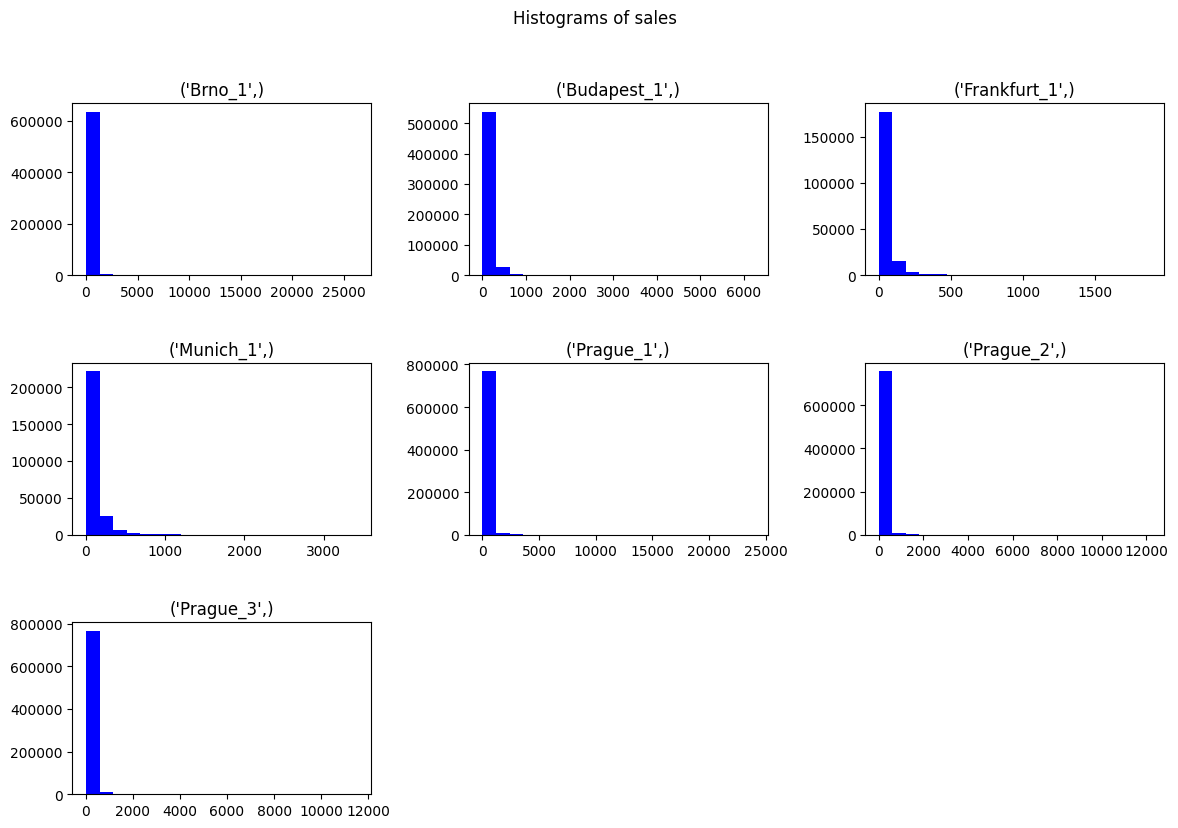

In [24]:
plt.figure(figsize=(12, 8))
for i, (combi, df) in enumerate(sales_train.groupby(['warehouse'],observed=False)):
    ax = plt.subplot(3, 3, i+1)
    ax.hist(df.sales, bins=20, color='blue')
    #ax.set_xscale('log')
    ax.set_title(combi)
plt.suptitle('Histograms of sales', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

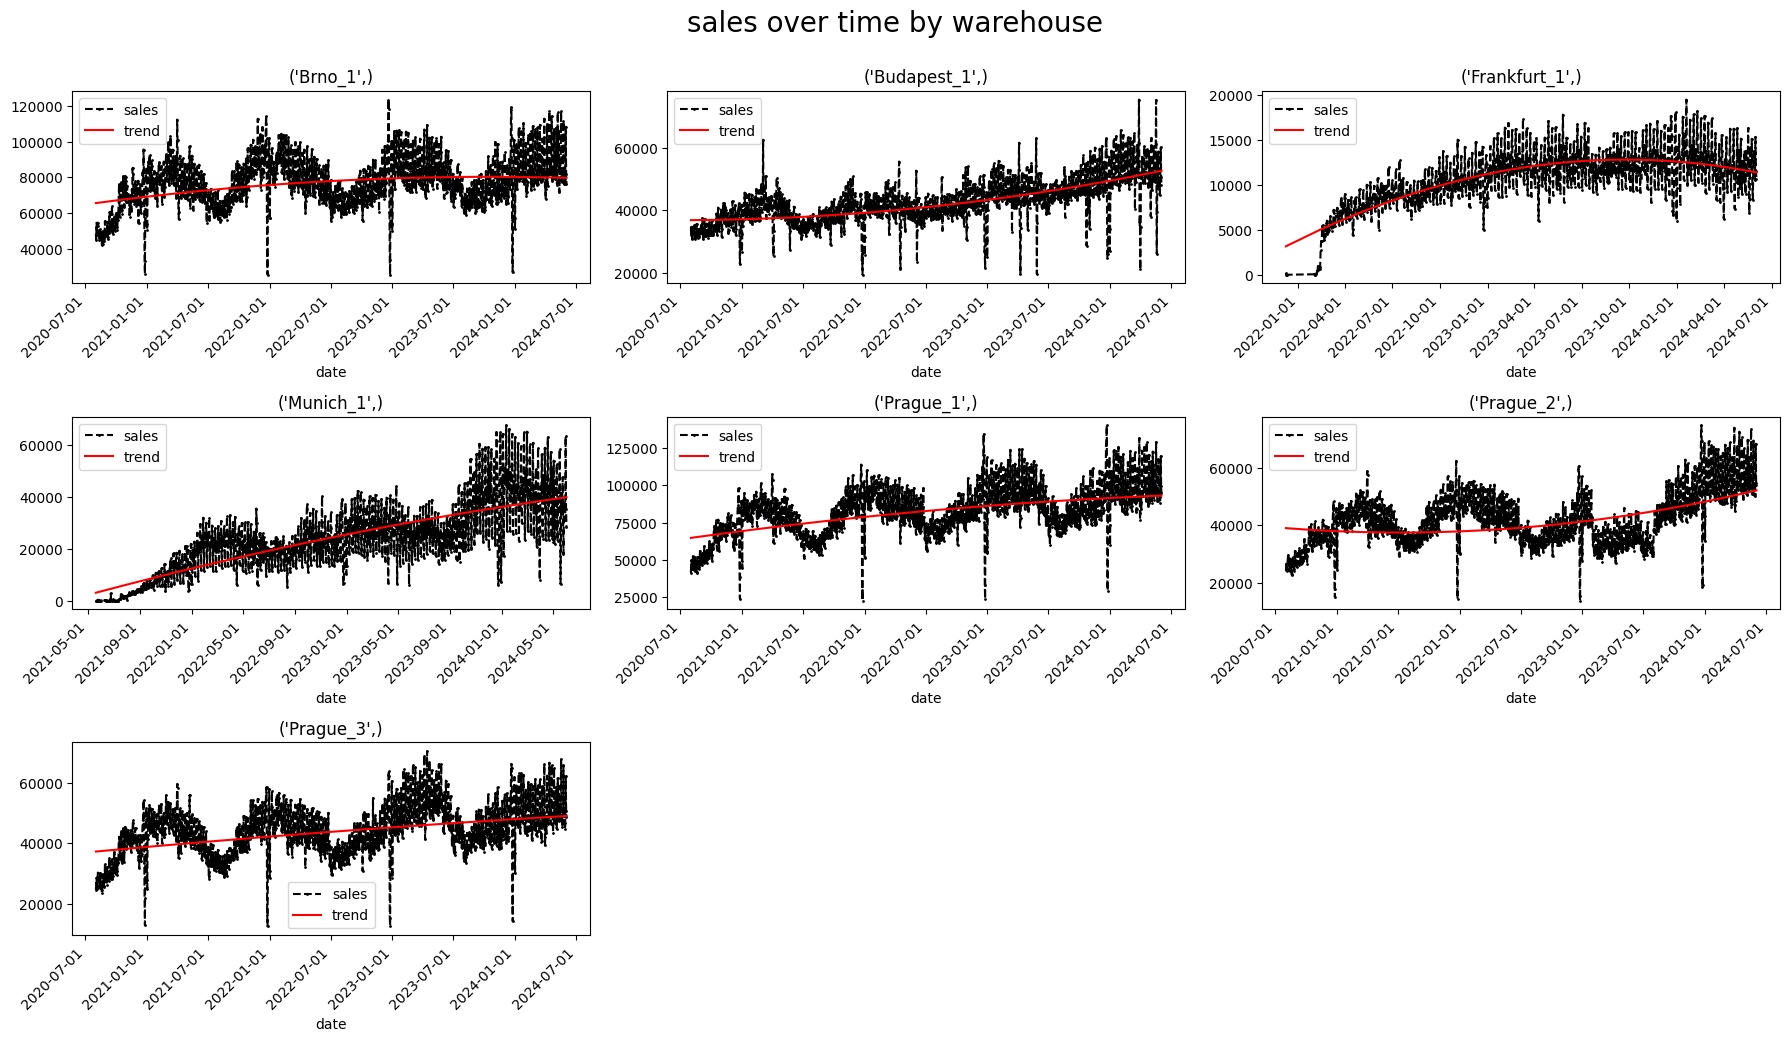

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

plt.figure(figsize=(18,22))
for i, (comb, df) in enumerate(sales_train.groupby(['warehouse'], observed=False)):
    ax = plt.subplot(7,3, i+1)
    sales = df.sort_values(by='date').groupby('date')['sales'].sum().reset_index()
    trend = (sales.date - sales.iloc[0].date) // dt.timedelta(days=1)
    trend = trend.values.reshape(-1,1)
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(trend,sales.sales)
    y_pred = pd.Series(model.predict(trend), index=sales.date)

    ax.plot(sales.date,sales.sales,label='sales', color='black',marker='o',ls='--',markersize=1)
    y_pred.plot(ax=ax,color='red',label='trend')
    ax.set_title(comb)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    ax.legend()


plt.tight_layout()
plt.suptitle('sales over time by warehouse',fontsize=20,y=1.02)
plt.show()

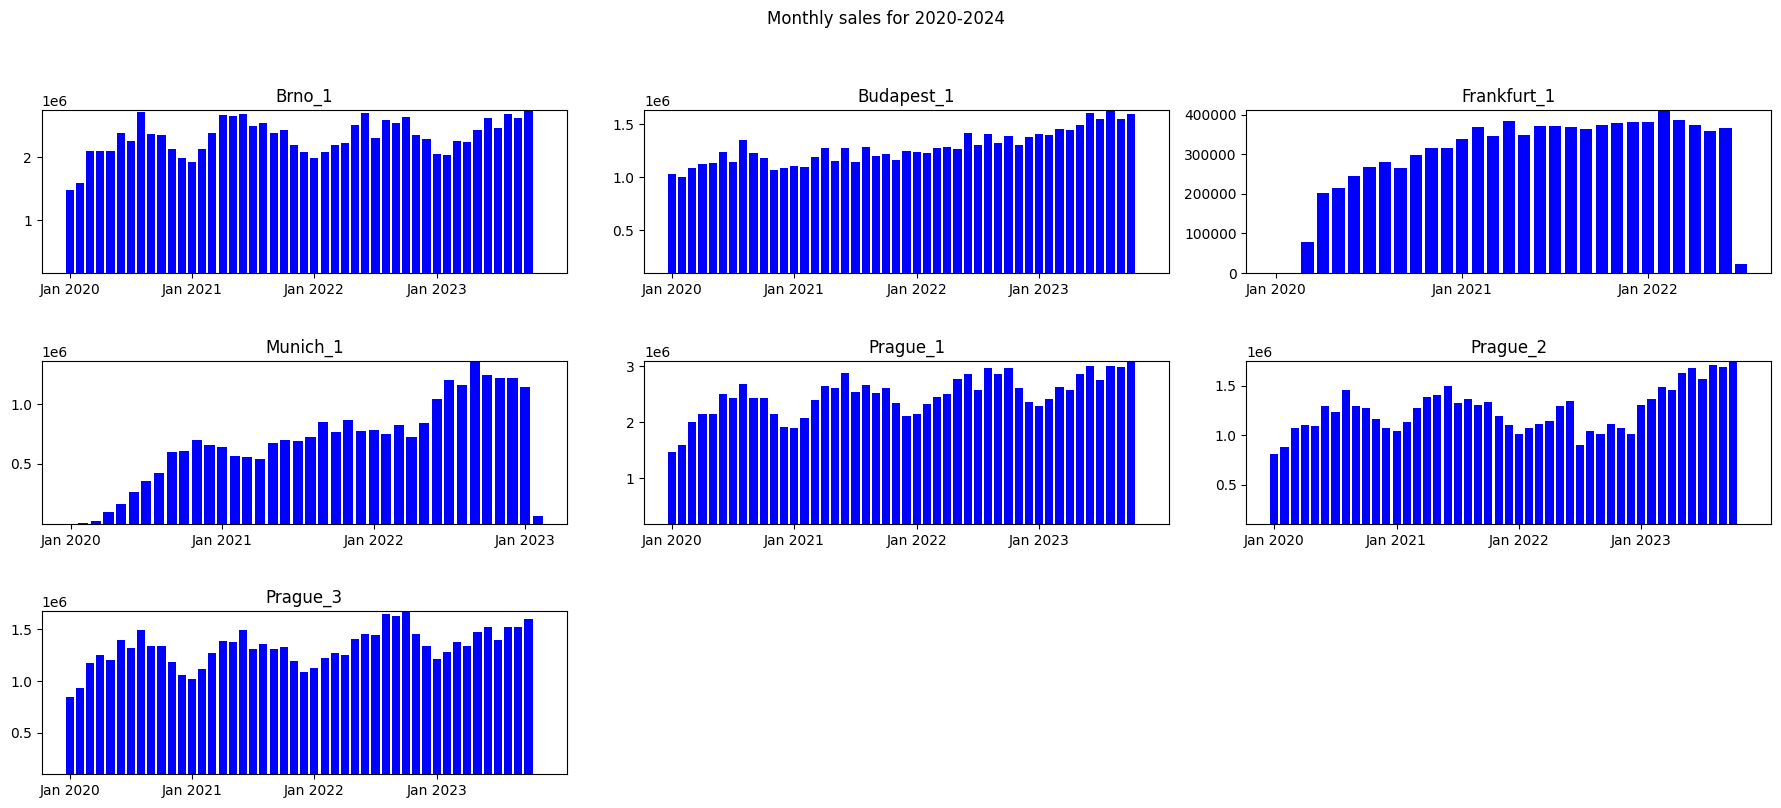

In [26]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)

    resampled = df.resample('MS').sales.sum()
    colors = ['blue'] * len(resampled)
    ax.set_title(comb)
    ax.set_ylim(resampled.min(), resampled.max())
    ax.bar(range(len(resampled)), resampled)
    ax.set_xticks(range(0, 48, 12), [f"Jan {y}" for y in range(2020, 2024)])
    ax.bar(range(len(resampled)), resampled, color=colors)

plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

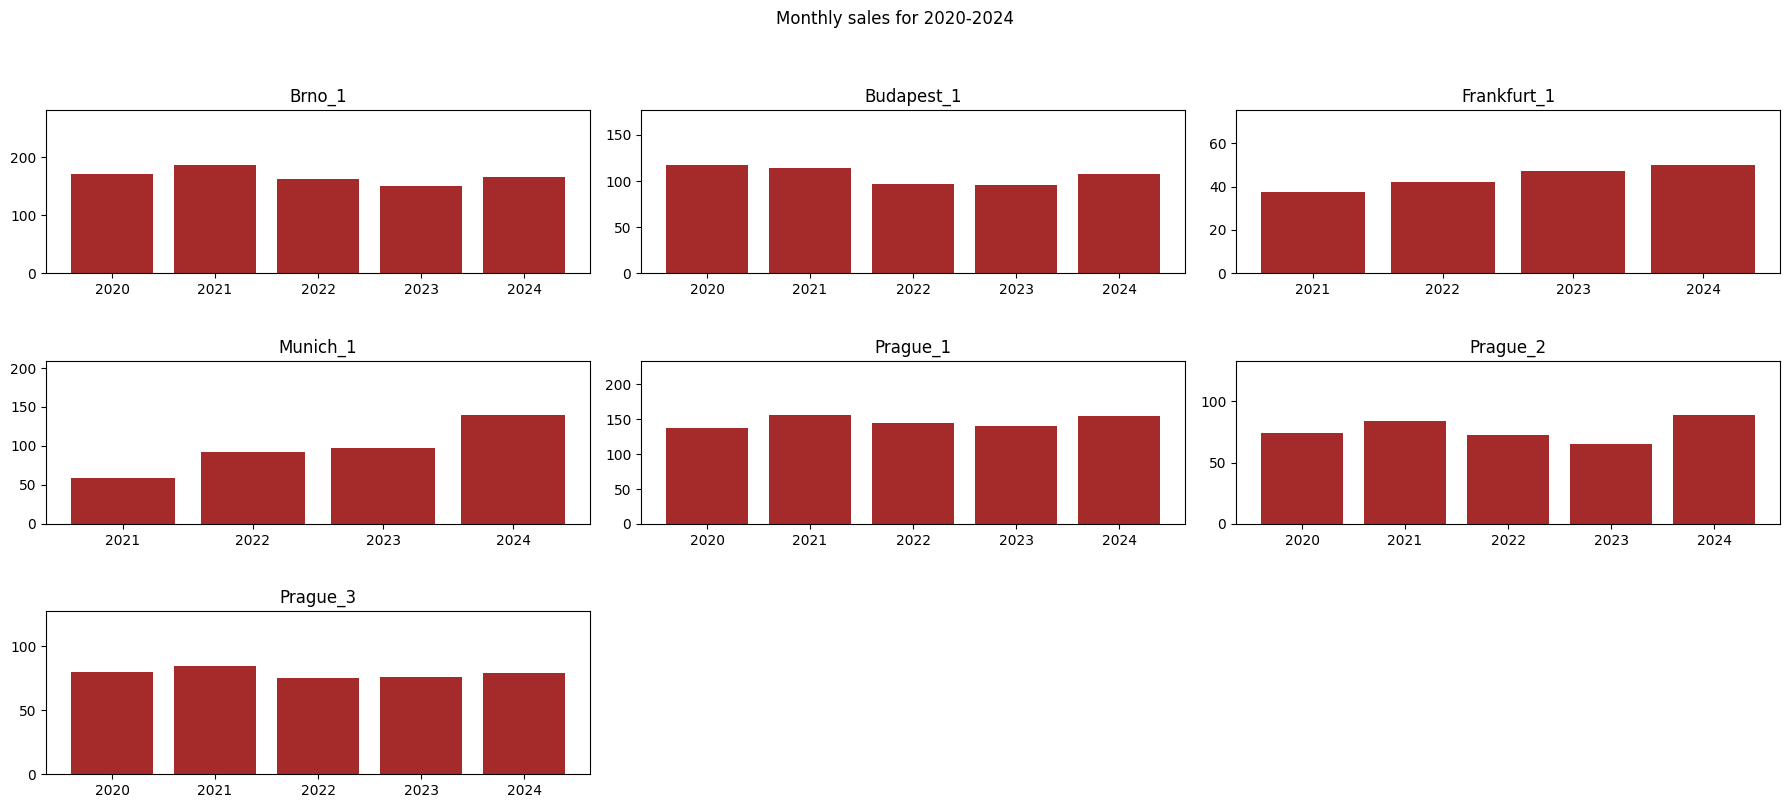

In [27]:
plt.figure(figsize=(18,10))
for i, (comb, df) in enumerate(sales_train.groupby(sales_train.warehouse,observed=False)):
    ax = plt.subplot(4, 3, i+1, ymargin=0.5)

    resampled = df.resample('YS')[['sales']].mean().reset_index()
    ax.bar(resampled.date.dt.year, resampled.sales, color='brown')
    ax.set_title(comb)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    #ax.set_ylim(0, resampled.sales.max())


plt.suptitle('Monthly sales for 2020-2024', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()